In [1]:
import neat
import os

In [2]:
#os.system('compilechannels nest neuron models/channels/channels_hay.py --name bac_firing --nestmlresource bac_firing_syns.nestml')

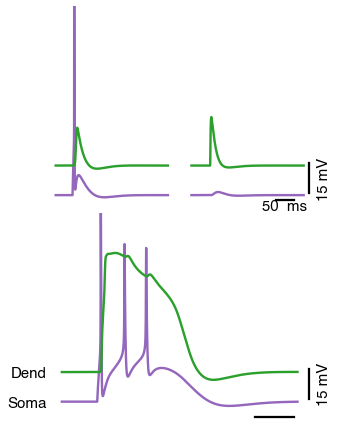

In [3]:
import numpy as np
import nest

from neat import createNestModel

import pickle

from models.L5_pyramid import getL5Pyramid
from plotutil import *

"""
compilechannels nest models/channels/channels_hay.py --name bac_firing --nestmlresource bac_firing_syns.nestml
"""
nest.Install("bac_firing_neatmodule")


def runCaCoinc(c_tree,
               ca_loc_idx, soma_ind,
               stim_type='psp',
               dt=0.05, t_max=300., t_calibrate=400.,
               psp_params=dict(tau_r_PSC=.5, tau_d_PSC=5., PSC_amp=.5, t_PSC=50.),
               i_in_params=dict(i_amp=1.9, t_onset=45., t_dur=5.),
               rec_kwargs=dict(record_from_syns=False, record_from_iclamps=False,
                               record_from_vclamps=False, record_from_channels=False,
                               record_v_deriv=False),
               pprint=True):
    """
    Runs the BAC-firing protocol to elicit an AP burst in response to coincident
    somatic and dendritic input
    """
    idx_calibrate = int(t_calibrate / dt)

    nest.ResetKernel()
    nest.SetKernelStatus(dict(resolution=dt, min_delay=dt, max_delay=1.5))

    # initialize the NEST model
    cm = createNestModel(c_tree, 'bac_firing')

    if stim_type == 'psp' or stim_type == 'coinc':
        syn_idx = nest.AddReceptor(cm, ca_loc_idx, "PSC", psp_params)
        sg_psc = nest.Create('spike_generator', 1, {'spike_times': [psp_params['t_PSC']+t_calibrate]})
        nest.Connect(sg_psc, cm, syn_spec={
            'synapse_model': 'static_synapse', 'weight': 1., 'delay': 0.1, 'receptor_type': syn_idx})

    if stim_type == 'current' or stim_type == 'coinc':
        dcg = nest.Create('dc_generator', {"amplitude": i_in_params['i_amp'],
                                           "start": i_in_params['t_onset']+t_calibrate,
                                           "stop": i_in_params['t_onset']+i_in_params['t_dur']+t_calibrate})
        nest.Connect(dcg, cm, syn_spec={
                    'synapse_model': 'static_synapse', 'weight': 1., 'delay': 2.*dt, 'receptor_type': soma_ind})

    mm = nest.Create('multimeter', 1, {'record_from': ['V_m_%d'%node.index for node in c_tree], 'interval': dt})
    nest.Connect(mm, cm)

    # simulate the NEST model
    nest.Simulate(t_max+t_calibrate)
    res = nest.GetStatus(mm, 'events')[0]

    for key in res:
        res[key] = res[key][idx_calibrate:]
        if key == 'times':
            res[key] -= res[key][0]

    return res


def runCalciumCoinc(dt=0.05):
    import bac_firing

    lss_ = ['-', '-.', '--']
    css_ = [colours[3], colours[0], colours[1]]
    lws_ = [.8, 1.2, 1.6]
    pl.figure('V trace', figsize=(6,8))
    gs = GridSpec(2,2)
    gs.update(top=.9, bottom=.2, left=.3, right=.9, hspace=.05, wspace=.1)
    axes_trace = [pl.subplot(gs[0,0]), pl.subplot(gs[0,1]), pl.subplot(gs[1,:])]
    vd_offset = 7.2
    vlim = (-80.,20.)

    # create the full model
    phys_tree = getL5Pyramid()

    # single branch initiation zone
    branch = phys_tree.path_to_root(phys_tree[236])[::-1]
    locs_sb = phys_tree.distribute_locs_on_nodes(bac_firing.D2S_CASPIKE, node_arg=branch, name='single branch')
    # abpical trunk locations
    apic = phys_tree.path_to_root(phys_tree[221])[::-1]
    locs_apic = phys_tree.distribute_locs_on_nodes(bac_firing.D2S_APIC, node_arg=apic, name='apic connection')

    # store set of locations
    fit_locs = [(1, .5)] + locs_apic + locs_sb
    phys_tree.store_locs(fit_locs, name='ca coinc')
    # PSP input location index
    ca_ind = phys_tree.get_nearest_loc_idxs([bac_firing.CA_LOC], name='ca coinc')[0]

    # obtain the simplified tree
    file = open('data/ctree_bac_firing.p', 'rb')
    ctree = pickle.load(file)
    clocs = pickle.load(file)
    file.close()

    for jj, stim in enumerate(['current', 'psp', 'coinc']):
        # runn the simulation
        res = runCaCoinc(ctree, ca_ind, 0, stim_type=stim, dt=dt,
                    rec_kwargs=dict(record_from_syns=True, record_from_iclamps=True))

        # somatic trace
        ax = axes_trace[jj]
        ax.set_xticks([0.,50.])
        ax.plot(res['times'], res['V_m_0'], c=cll[0], lw=1.6*lwidth)

        # dendritic trace
        ax.plot(res['times'], res['V_m_%d'%ca_ind]+vd_offset, c=cll[1], lw=1.6*lwidth)

        ax.set_yticks([res['V_m_0'][0], res['V_m_%d'%ca_ind][0]+vd_offset])
        if jj == 1 or jj == 2:
            drawScaleBars(ax, xlabel=' ms', ylabel=' mV', b_offset=15)
            # drawScaleBars(ax, xlabel=' ms', b_offset=25)
        else:
            drawScaleBars(ax)
        if jj == 2:
            ax.set_yticklabels([r'Soma', r'Dend'])
        ax.set_ylim(vlim)

runCalciumCoinc()